# Simulation of a Single-Server Queueing System (Banking Queue System)

This notebook simulates a banking queue system using the `simpy` library. 

The simulation models customer arrivals, service times, and queue dynamics to analyze various performance metrics of the system. The key components of the simulation include:

- **Customer**: Represents a customer in the system, with attributes such as arrival time, service time, and delay experienced.
- **Cashier**: Represents a single server (teller) in the bank, managing the queue and processing customers.
- **Bank**: Represents the overall banking system, managing customer arrivals and interactions with the cashier.

## Objectives

We aim to measure and analyze the following performance metrics:

1. **Average inter-arrival time $E[1/λ]$**: The average time between customer arrivals.
2. **Average service time $E[S]$**: The average time taken to serve a customer.
3. **Average delay time $E[D]$**: The average time customers spend waiting in the queue.
4. **Average number of customers in the queue $E[Q]$**: The average queue length over time.
5. **Server utilization rate $E[U]$**: The proportion of time the server is busy.

In [4]:
from __future__ import annotations

import random
import statistics
from collections import defaultdict
from collections.abc import Generator, Iterable
from typing import Any, NoReturn

import matplotlib.pyplot as plt
import simpy
from simpy import Process
from simpy.events import Timeout
from simpy.resources.resource import Release, Request

In [3]:
class Customer:
    def __init__(
        self,
        env: simpy.Environment,
        bank: Bank,
        arrival_time: float,
        service_time: float,
    ) -> None:
        self.env = env
        self.bank = bank
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time

        self.delay: float | None = None

    def main(self) -> Generator[Request | Process, Any, None]:
        # Request the cashier
        with self.bank.cashier.request() as request:
            # Record the time the customer joined the queue
            queue_entry_time = self.env.now

            # Wait for the cashier to become available
            yield request

            # Record the time the customer left the queue
            queue_exit_time = self.env.now

            # Calculate the time the customer spent waiting in the queue
            self.delay = queue_exit_time - queue_entry_time

            # Wait for the cashier to process the customer
            yield self.env.process(self.bank.cashier.process_customer(self))


In [5]:
class Cashier(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.queue_history: dict[int, float] = defaultdict(float)
        # queue time points
        self.qt: list[tuple[float, int]] = []
        # utilization rate time points
        self.ut: list[tuple[float, int]] = [(0, 0)]

        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0

        self.worked_time: float = 0

    @property
    def average_queue_length(self) -> float:
        return (
            sum(
                queue_length * time for queue_length, time in self.queue_history.items()
            )
            / self.env.now
        )

    @property
    def utilization_rate(self) -> float:
        return self.worked_time / self.env.now

    def _update_qt(self) -> None:
        self.qt.append((self.env.now, len(self.queue)))

    def _update_ut(self) -> None:
        status = int(self.count == 1 or len(self.queue) > 0)
        if self.ut and self.ut[-1][1] == status:
            return
        self.ut.append((self.env.now, status))

    def _update_queue_history(self, _) -> None:
        self.queue_history[self.last_queue_level] += (
            self.env.now - self.last_queue_level_timestamp
        )
        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self._update_qt()

    def request(self) -> Request:
        request = super().request()
        self._update_queue_history(None)

        request.callbacks.append(self._update_queue_history)
        return request

    def release(self, request: Request) -> Release:
        release = super().release(request)
        self._update_ut()
        return release

    def process_customer(self, customer: Customer) -> Generator[Timeout, None, None]:
        yield self.env.timeout(customer.service_time)
        self.worked_time += customer.service_time

    def plot_qt(self) -> None:
        x, y = zip(*self.qt)
        plt.step(x, y, where="pre")
        plt.fill_between(x, y, step="pre", alpha=1.0)
        plt.title("Q(t): Queue length over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Queue Length")
        plt.show()

    def plot_ut(self) -> None:
        ut = self.ut + [(self.env.now, self.ut[-1][1])]
        x, y = zip(*ut)
        plt.step(x, y, where="post")
        plt.fill_between(x, y, step="post", alpha=1.0)
        plt.title("U(t): Cashier utilization over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Utilization rate")
        plt.show()


In [6]:
class Bank:
    def __init__(
        self,
        env: simpy.Environment,
        customer_arrival_rate: float,
        customer_average_processing_time: float,
    ) -> None:
        self.env = env
        
        # M/M/1 queueing system
        self.cashier = Cashier(env, capacity=1)

        # Rate of customer arrivals
        # λ = 1 / mean, where λ is the rate parameter [customers/minute]
        self.customer_arrival_rate = customer_arrival_rate

        # Average processing time for a customer
        # [minutes/customer]
        self.customer_average_processing_time = customer_average_processing_time

        self.customers_inter_arrival_times: list[float] = []
        self.customers: list[Customer] = []

    @property
    def customer_service_times(self) -> Iterable[float]:
        for customer in self.customers:
            yield customer.service_time

    @property
    def customer_delay_times(self) -> Iterable[float]:
        for customer in self.customers:
            if customer.delay is not None:
                yield customer.delay

    def run(self) -> Generator[Timeout, Any, NoReturn]:
        while True:
            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average delta time from one customer to the next (in minutes)
            customer_inter_arrival_time = random.expovariate(
                lambd=self.customer_arrival_rate
            )
            self.customers_inter_arrival_times.append(customer_inter_arrival_time)

            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average processing time for a customer (in minutes)
            customer_service_time = random.expovariate(
                1 / self.customer_average_processing_time
            )

            # Wait for the next customer to arrive
            yield self.env.timeout(customer_inter_arrival_time)

            # Generate a new customer
            customer = Customer(
                env=self.env,
                bank=self,
                arrival_time=self.env.now,
                service_time=customer_service_time,
            )
            self.customers.append(customer)

            self.env.process(customer.main())


In [7]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env,
    # n customers/minute --> 1/n minutes/customer
    customer_arrival_rate=4,
    # 1/n minutes/customer --> n customers/minute
    customer_average_processing_time=1 / 5,
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # minutes

## Average inter-arrival time E[1/λ]

Average Customer Inter-arrival time = 0.25 minutes


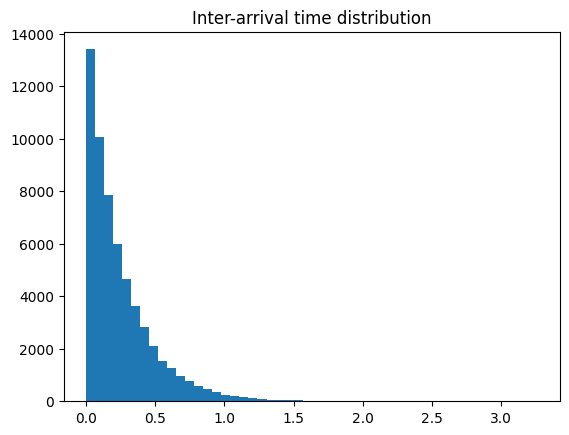

In [8]:
average_customer_inter_arrival_time = statistics.mean(
    bank.customers_inter_arrival_times
)
print(
    f"Average Customer Inter-arrival time = {average_customer_inter_arrival_time:.2f} minutes"
)
plt.hist(bank.customers_inter_arrival_times, bins=50)
plt.title("Inter-arrival time distribution")
plt.show()

## Average service time E[S]

Average Customer service time = 0.20 minutes


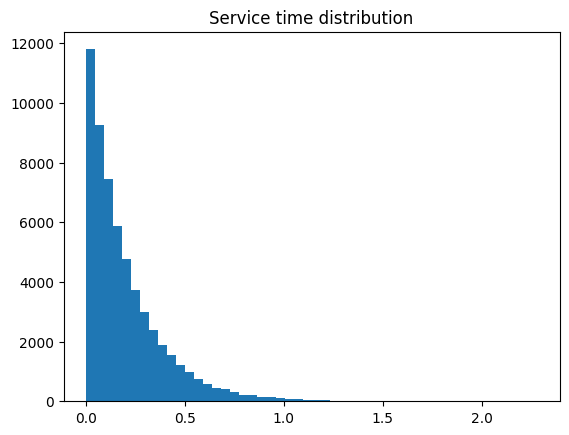

In [9]:
average_customer_service_time = statistics.mean(bank.customer_service_times)
print(f"Average Customer service time = {average_customer_service_time:.2f} minutes")
plt.hist(list(bank.customer_service_times), bins=50)
plt.title("Service time distribution")
plt.show()

## Average delay time E[D]

Average Customer delay time = 0.83 minutes


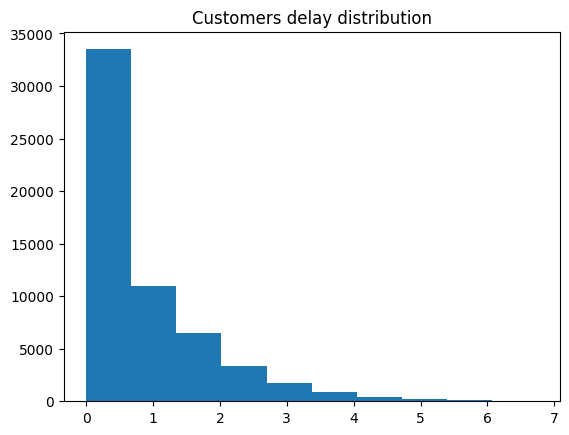

In [10]:
average_customer_delay_time = statistics.mean(bank.customer_delay_times)
print(f"Average Customer delay time = {average_customer_delay_time:.2f} minutes")
plt.hist(list(bank.customer_delay_times), bins=10)
plt.title("Customers delay distribution")
plt.show()

## Average number of customers in the queue E[Q]

Average Cashier queue length = 3.30


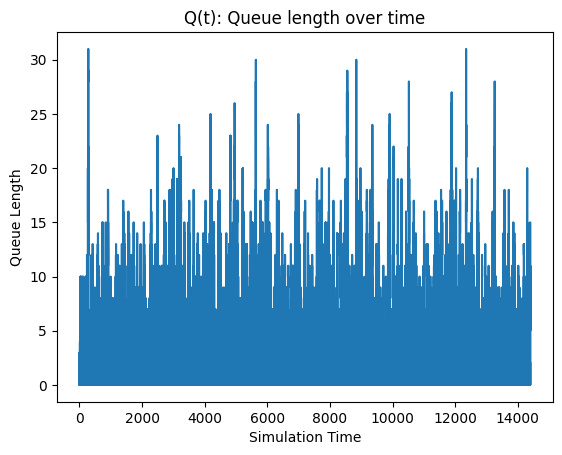

In [11]:
average_cashier_queue_length = bank.cashier.average_queue_length
print(f"Average Cashier queue length = {average_cashier_queue_length:.2f}")
bank.cashier.plot_qt()

## Server utilization rate E[U]

Average Server Utilization rate = 80.20%


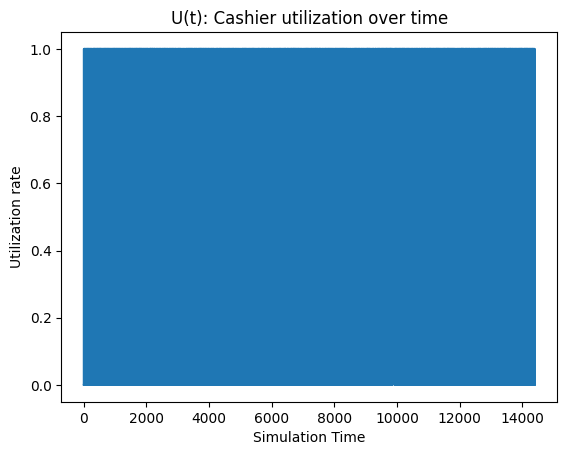

In [12]:
average_utilization_rate = bank.cashier.utilization_rate
print(f"Average Server Utilization rate = {average_utilization_rate * 100:.2f}%")
bank.cashier.plot_ut()

In [16]:
random.seed(None)

from tqdm import tqdm

results = []
for _ in tqdm(range(50)):
    random.seed(_)
    env = simpy.Environment()
    bank = Bank(
        env,
        customer_arrival_rate=4,
        customer_average_processing_time=1 / 5,
    )
    env.process(bank.run())
    env.run(until=60 * 24 * 50)  # minutes
    results.append(bank.cashier.average_queue_length)

100%|██████████| 50/50 [02:35<00:00,  3.11s/it]


In [17]:
m = statistics.mean(results)
s = statistics.stdev(results)

# margin of error
# 95% confidence interval
# z = 1.96 for 95% confidence
# z = 2.576 for 99% confidence
moe = 1.96 * s / len(results) ** 0.5

print(f"Average Cashier queue length = {m:.2f} ± {moe:.2f}")

Average Cashier queue length = 3.19 ± 0.02


In [18]:
ro = 0.8  # true utilization rate (aka traffic intensity)
true_average_queue_length = ro**2 / (1 - ro)
print(f"Average Queue Length = {true_average_queue_length:.2f}")
m - moe <= true_average_queue_length <= m + moe

Average Queue Length = 3.20


True

## Banking System with Jockeying

Implement a banking queue system with multiple tellers (start with 5 servers) and jockeying.

Each teller has a separate queue.

An arriving customer joins the shortest queue, choosing the leftmost shortest queue in case of ties.

Let $n_i$ be the total number of customers in front of teller $i$ (including customers in queue as well as the customer in service, if any) at a particular instant. 

If the completion of a customer’s service at teller i causes $n_j$ > $n_i + 1$ for some other teller $j$, then the customer from the tail of queue $j$ jockeys (moves) to the tail of queue $i$.

Assume:
  - Interarrival times of customers are exponentially distributed with a mean of 1 minute ($\mu=1$).
  - Service times are exponentially distributed with a mean of 4.5 minutes ($\mu=4.5$).

Measure system performance for systems with 4, 5, 6, and 7 tellers.

## Banking System with Impatient Customers

Implement a banking queue system with single teller and impatient customers.

Customers arrive at the bank at an average rate of 5 per minute ($\lambda=5$) and are served by a single teller whose service times are exponentially distributed with a mean of 6 minutes ($\mu=6$).

If a customer finds the teller busy, they wait in the queue. However, if the customer waits for more than 10 minutes and the teller is still busy, the customer leaves the bank.

Simulate the system and measure the following performance measures:
  - Average number of customers in the queue
  - Average number of customers who leave the bank without being served